  # Transactions PCA

## 1. Import required libraries

In [1]:
if(!is.element("FactoMineR", installed.packages()[,1])){
  install.packages("FactoMineR", dependencies=TRUE)
}

if(!is.element("factoextra", installed.packages()[,1])){
  install.packages("factoextra", dependencies=TRUE)
}

if(!is.element("devtools", installed.packages()[,1])){
  install.packages("devtools")
}

if(!is.element("DBI", installed.packages()[,1])){
  devtools::install_github("rstats-db/DBI")
}

if(!is.element("RPostgres", installed.packages()[,1])){
  devtools::install_github("rstats-db/RPostgres")
}

library(FactoMineR)
library(factoextra)
library(RPostgres)
library(DBI)

Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



## 2. Load data from Database using SQL query

In [16]:
con <- dbConnect(RPostgres::Postgres(), host='localhost', port='5433', dbname='bandit-nbs', user='bandit', password="orF9YuPWVajej5tC6cfiro94BoxrzsoE")
transactions <- dbGetQuery(con, 'SELECT * FROM "Transaction"')
rownames(transactions) <- transactions$Id
summary(transactions)

      Id             DebitBank          CreditBank          ClientId        
 Length:7980        Length:7980        Length:7980        Length:7980       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
 ClientGender       ClientBirthDate                      ClientAge    
 Length:7980        Min.   :1930-01-05 18:15:45.0000   Min.   :18.00  
 Class :character   1st Qu.:1948-07-24 10:45:09.2500   1st Qu.:34.00  
 Mode  :character   Median :1967-12-17 18:49:19.5000   Median :50.00  
                    Mean   :1968-01-07 03:15:07.1164   Mean   :49.93  
                    3rd Qu.:1987-09-27 16:49:25.5000   3rd Qu.:64.00  
                    Max.   :2005-12

As we can see in the summary, the columns are correctly interpreted, we can continue

## 3. Launch the PCA algorithm

Here we will launch the PCA Algorithm for FactoMineR, as the PCA only handle quantitative values, we need to specify which columns must be considered qualitative.
This way, we will be able to use them has an "habillage" for the graph of individuals in order to detect some correlation between the axes and our data.

In [17]:
acp <- PCA(transactions, graph=FALSE, quali.sup=c("Id","DebitBank","CreditBank","ClientId","ClientGender","ClientBirthDate","ClientMaritalStatus","TransactionDate","MerchantActivity", "AuthenticationMethod"))

Before going further and inspect the differents graphs, we will check the eigen values of the axes computed by the algorithm
to determine their implication in our data

In [26]:
acp$eig

,eigenvalue,percentage of variance,cumulative percentage of variance
comp 1,1.8526610,61.755365,61.75537
comp 2,0.9922496,33.074985,94.83035
comp 3,0.1550895,5.169649,100.00000


As we can see, we have 3 axes (because we only have 3 quantitative columns left), and the 2 first ones are explaing the most
part of our data (Respectively 61 and 33%, for a total of ~95%). Considering this, we will only work with those two.

As a bonus, we can visualize the implication of each axes in the following graph:

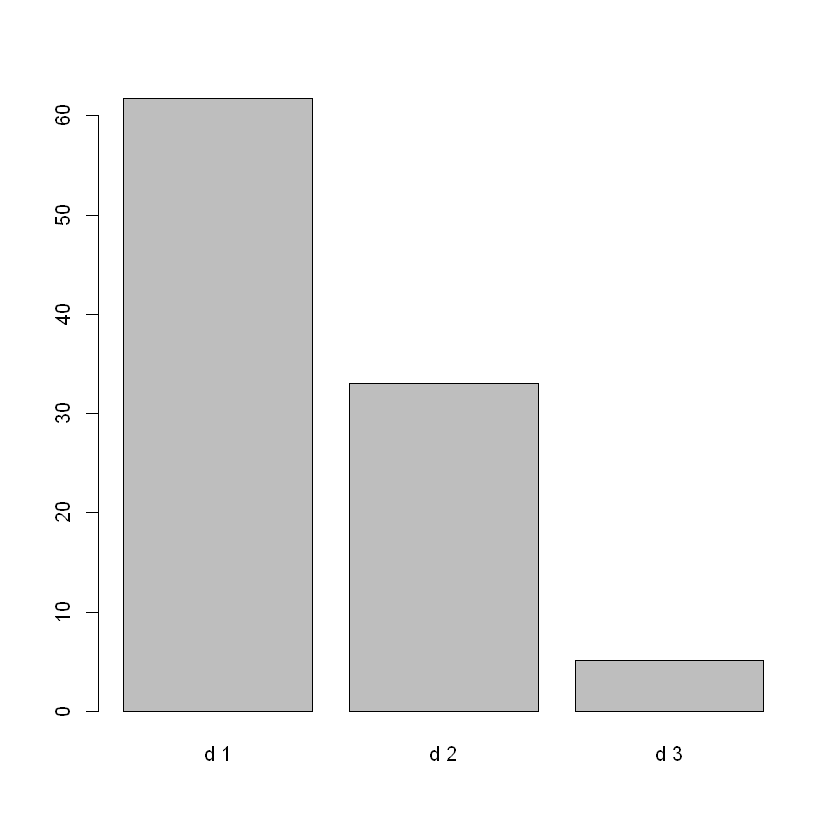

In [27]:
barplot(acp$eig[,2], names=paste("d",1:nrow(acp$eig)))

## 4. PCA Individuals factor map

First let's plot our acp with the following options
- **cex=0.6** : Size of the points
- **choix="ind"** : We precise that we want the individuals graph
- **invisible="quali"** : We want to hide qualitative (will quite speed up the generation of the graph)
- **label="none"** : Will hide the labels of the points, this is necessary otherwise the graph is unreadable

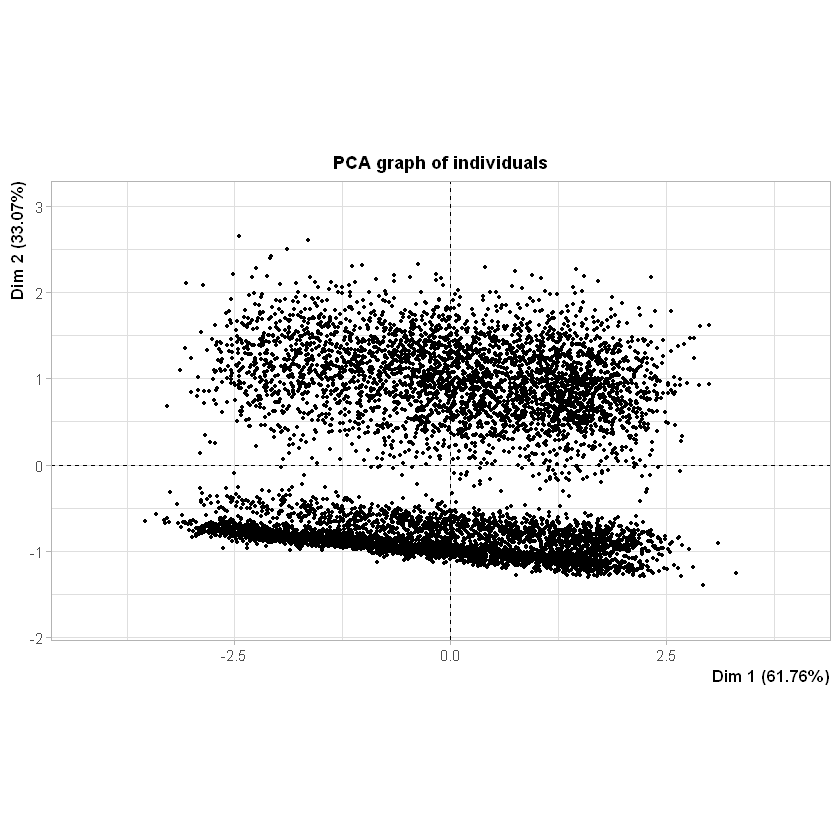

In [33]:
plot(acp, cex=0.6, choix="ind", invisible="quali", label="none")

Now that we have the raw PCA graph of individuals, we can play with the qualitative values and try to reveal a possible correlation
between our axes and our data points

**Note** : In order to be synthetic, I will only plot the intersting combinations

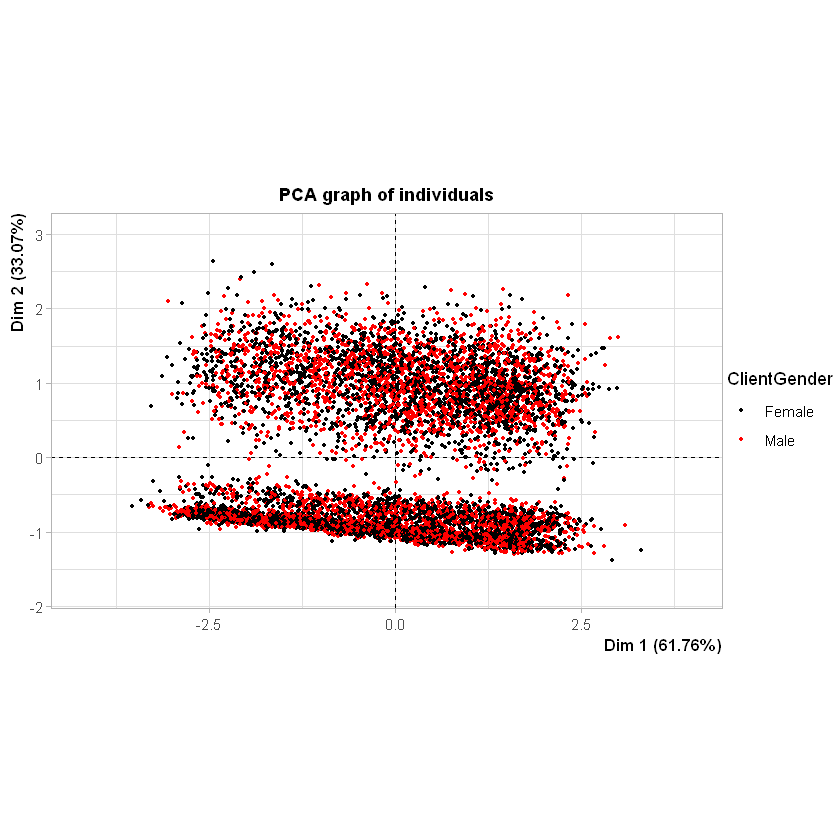

In [41]:
plot(acp, cex=0.6, choix="ind", invisible="quali", label="none", habillage = "ClientGender")

As we can see, our axes don't seem to be related to the client gender, let's continue

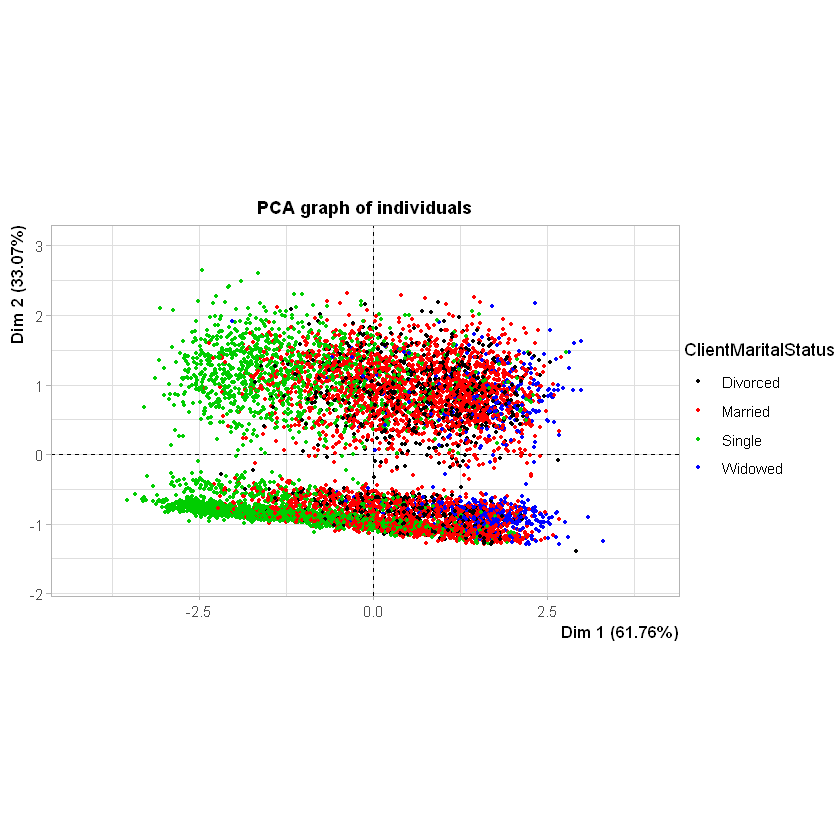

In [42]:
plot(acp, cex=0.6, choix="ind", invisible="quali", label="none", habillage = "ClientMaritalStatus")

At first glance, it may not seem very obvious but we can see something interesting here : we have a nice gradient from left to right of our modalities
We can suppose that there is a subtile relation between the first PCA axe and the marital status of the clients

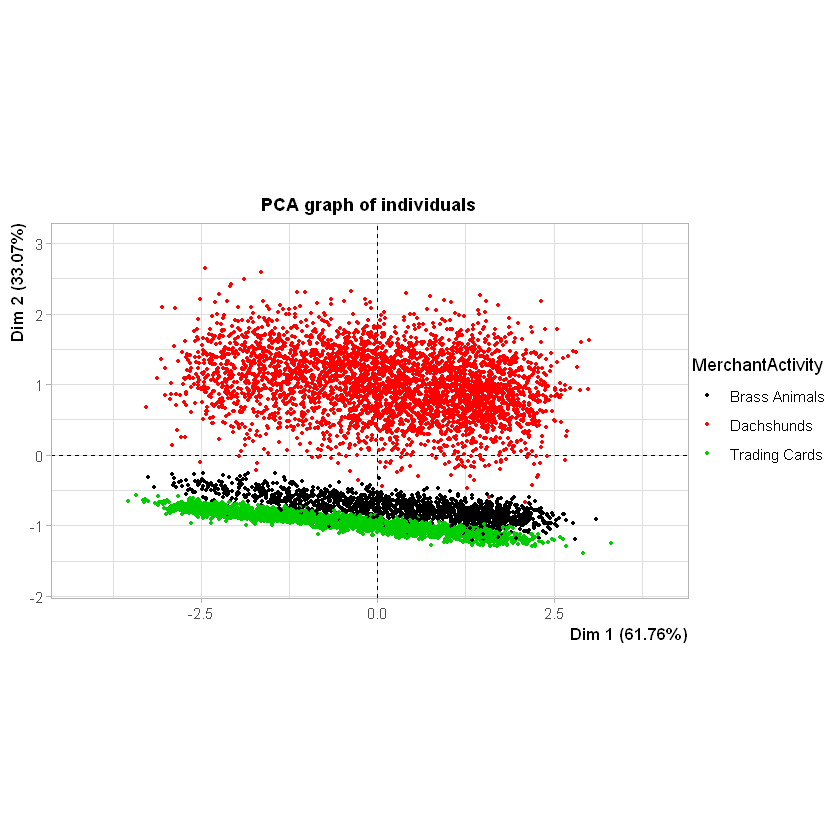

In [43]:
plot(acp, cex=0.6, choix="ind", invisible="quali", label="none", habillage = "MerchantActivity")

Here the result is striking: our vertical axis seems to have a very strong relationship with the merchants' sector of activity

We will clarify this relationship later, let's continue to explore the different classes in our data

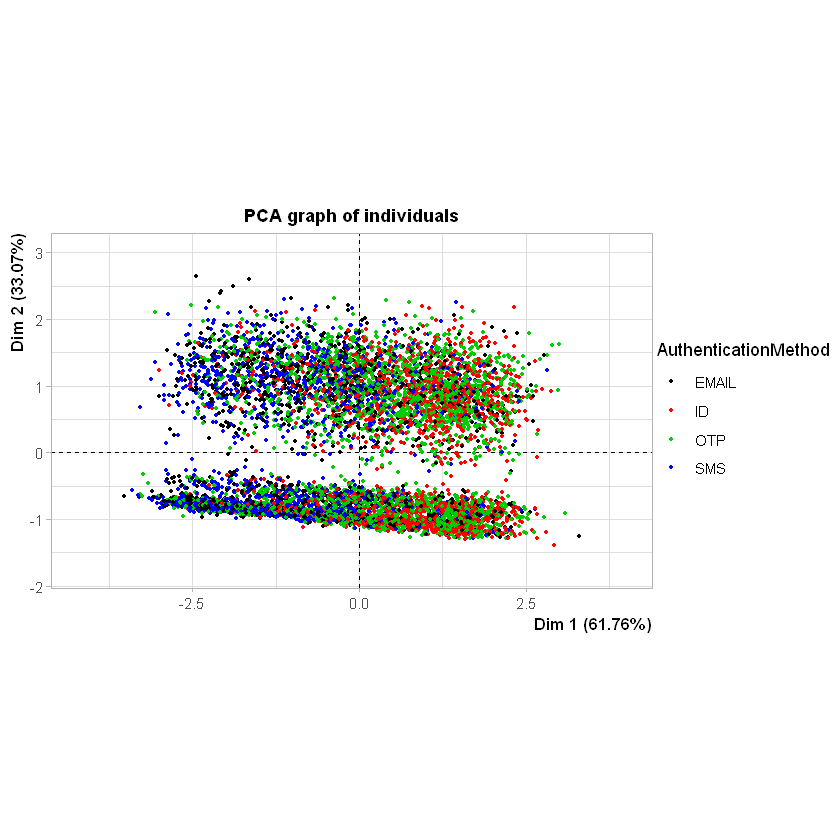

In [44]:
plot(acp, cex=0.6, choix="ind", invisible="quali", label="none", habillage = "AuthenticationMethod")

No findings can be made regarding the chosen authentication method

## 5. PCA variables factor map

Let's plot our acp with the following options
- **cex=0.6** : Size of the points
- **choix="ind"** : We precise that we want the individuals graph
- **invisible="quali"** : We want to hide qualitative (will quite speed up the generation of the graph)
- **label="none"** : Will hide the labels of the points, this is necessary otherwise the graph is unreadable

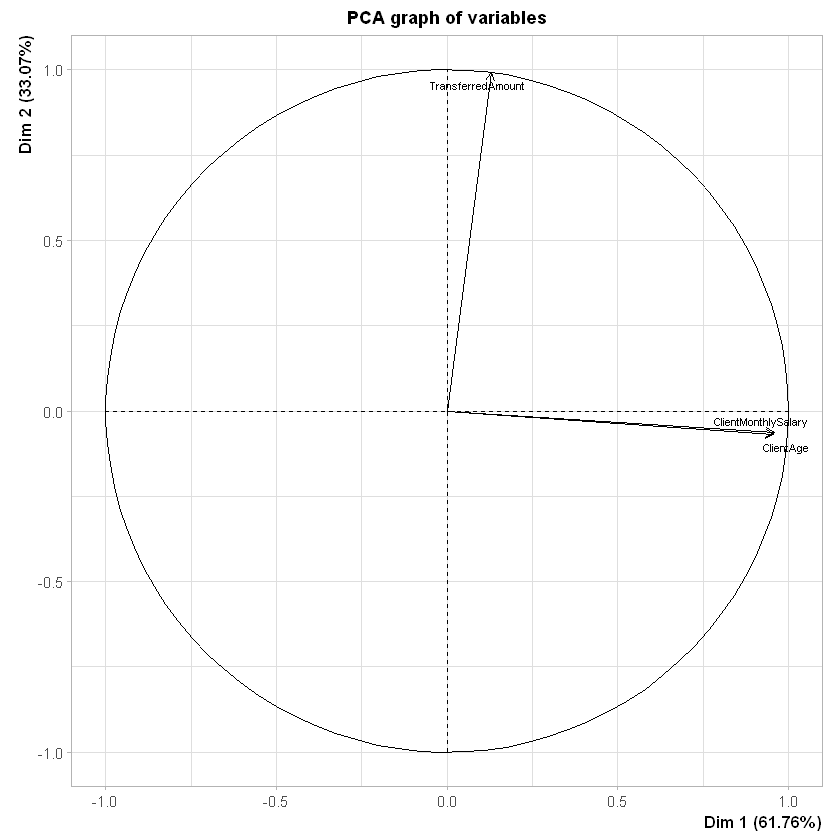

In [47]:
plot(acp, cex=0.6, choix="var")

**This graph is full of interesting information**, first let's focus on the horizontal axis.
As we can see, the age of the clients and their monthly salary seem to be almost perfectly correlated.
We can check this correlation with a simple regression-correlation:

[1] 0.8448982

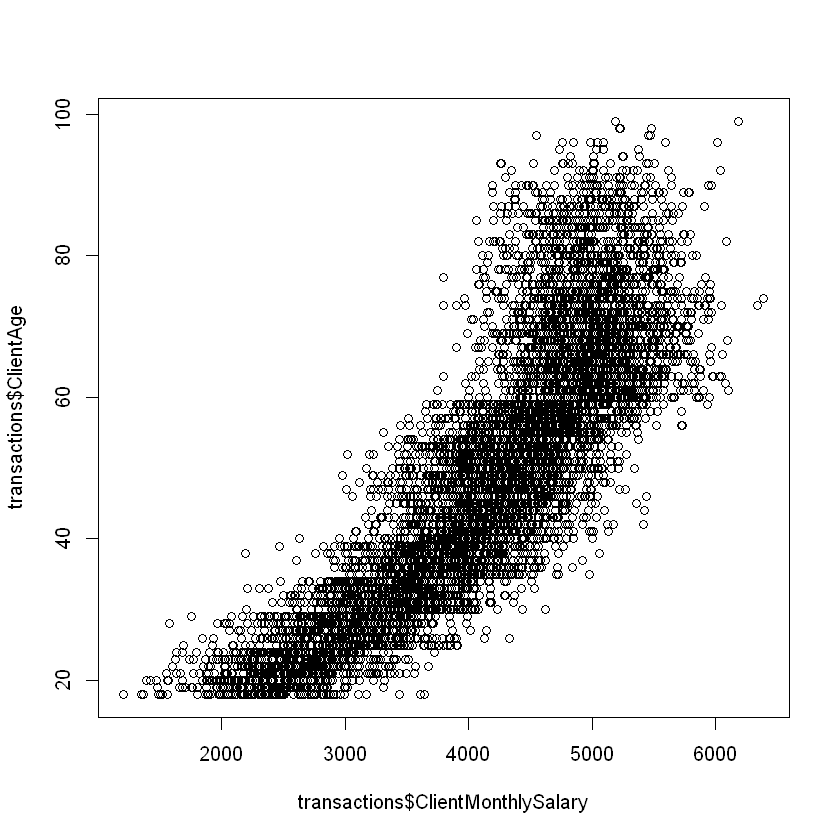

In [54]:
plot(transactions$ClientAge~transactions$ClientMonthlySalary)
cor(transactions$ClientAge, transactions$ClientMonthlySalary)

We can confirm this correlation by looking at the graph, and more precisely, by looking at the **R value of 0.84** which indicates a strong positive correlation

Moreover, we can cross-reference these results with one of our previous observations: the civil status of people seemed to be related to the horizontal axis of our PCA

Would that mean that the marital status of a person could be influenced by her age and/or her salary ?

Let's plot it !


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




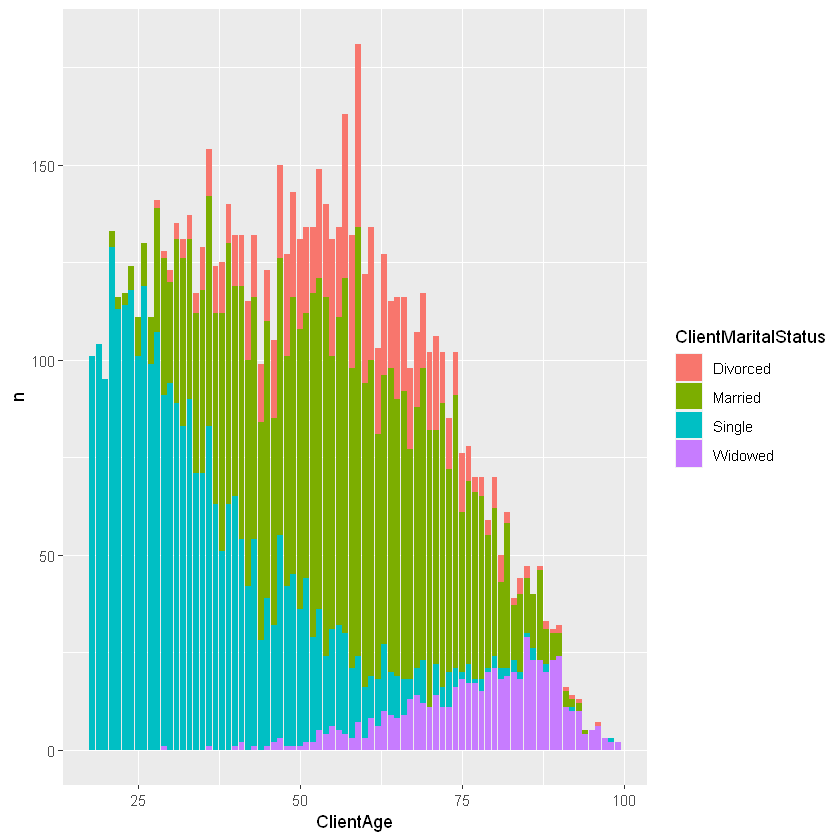

In [55]:
library(ggplot2)
library(dplyr)
counts <- transactions %>% count(ClientAge, ClientMaritalStatus)
ggplot(counts, aes(x = ClientAge, y = n, fill = ClientMaritalStatus)) + geom_col()

The correlation seems obvious, to prove it furthermore, let's do an ANOVA !

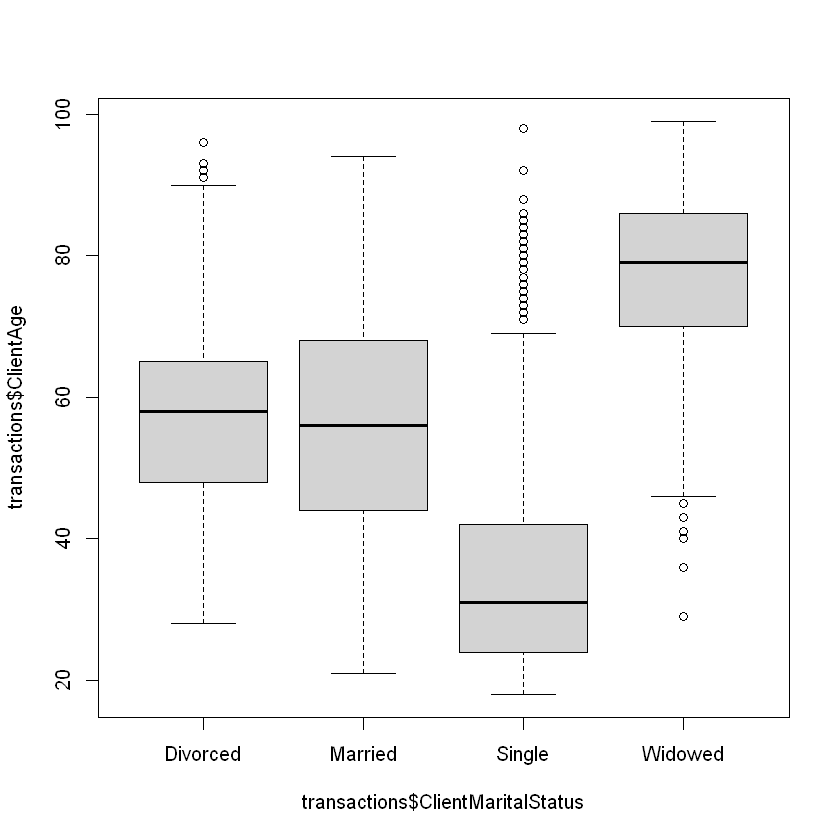

In [56]:
boxplot(transactions$ClientAge~transactions$ClientMaritalStatus)

In [61]:
model <- lm(transactions$ClientAge~transactions$ClientMaritalStatus)
summary(model)


Call:
lm(formula = transactions$ClientAge ~ transactions$ClientMaritalStatus)

Residuals:
    Min      1Q  Median      3Q     Max 
-48.242 -10.716  -1.085   9.884  63.284 

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                              57.1165     0.4542 125.755   <2e-16
transactions$ClientMaritalStatusMarried  -1.0311     0.5121  -2.014   0.0441
transactions$ClientMaritalStatusSingle  -22.4001     0.5229 -42.834   <2e-16
transactions$ClientMaritalStatusWidowed  20.1258     0.7360  27.343   <2e-16
                                           
(Intercept)                             ***
transactions$ClientMaritalStatusMarried *  
transactions$ClientMaritalStatusSingle  ***
transactions$ClientMaritalStatusWidowed ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 14.02 on 7976 degrees of freedom
Multiple R-squared:  0.4527,	Adjusted R-squared:  0.4525 
F-statistic:  2199 on 3

As we get a **p-value of 2.2e-16**, we can definively say that there is a correlation between the age and the marital status

After this little parenthesis about our horizontal axis, let's come back to our PCA variables graph to discuss about the vertical axis.

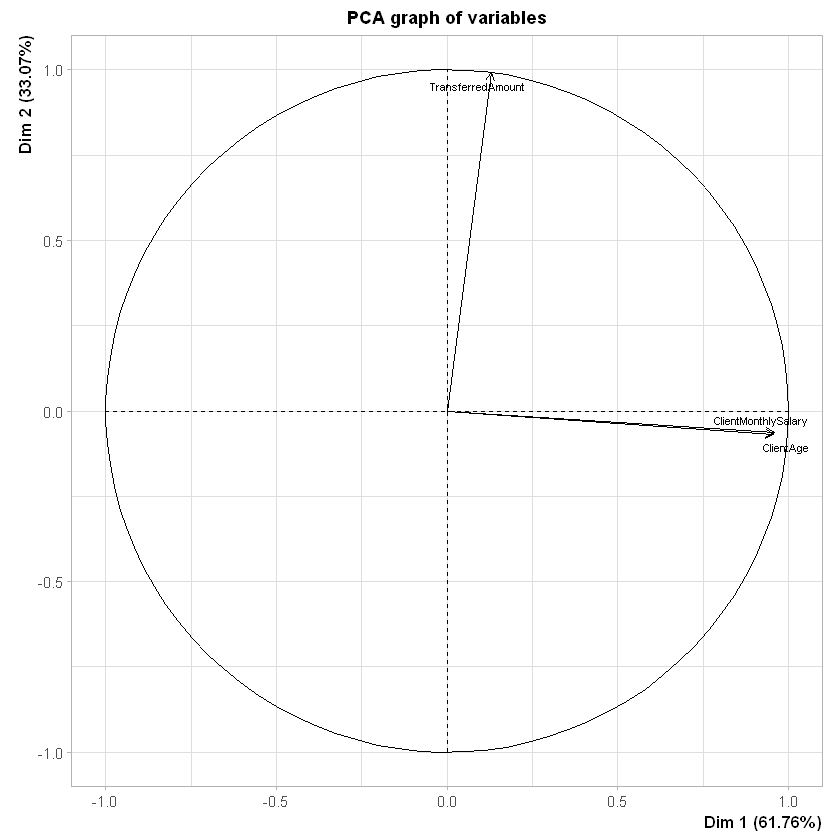

In [62]:
plot(acp, cex=0.6, choix="var")

We can see that the vertical axis seems highly correlated with the amount transferred.
Previously, we've also seen that the merchant activity seemed to be related to this same axis.
Can we imagine that the amount spent is influenced by the merchant industry?

To answer this question, ANOVA !

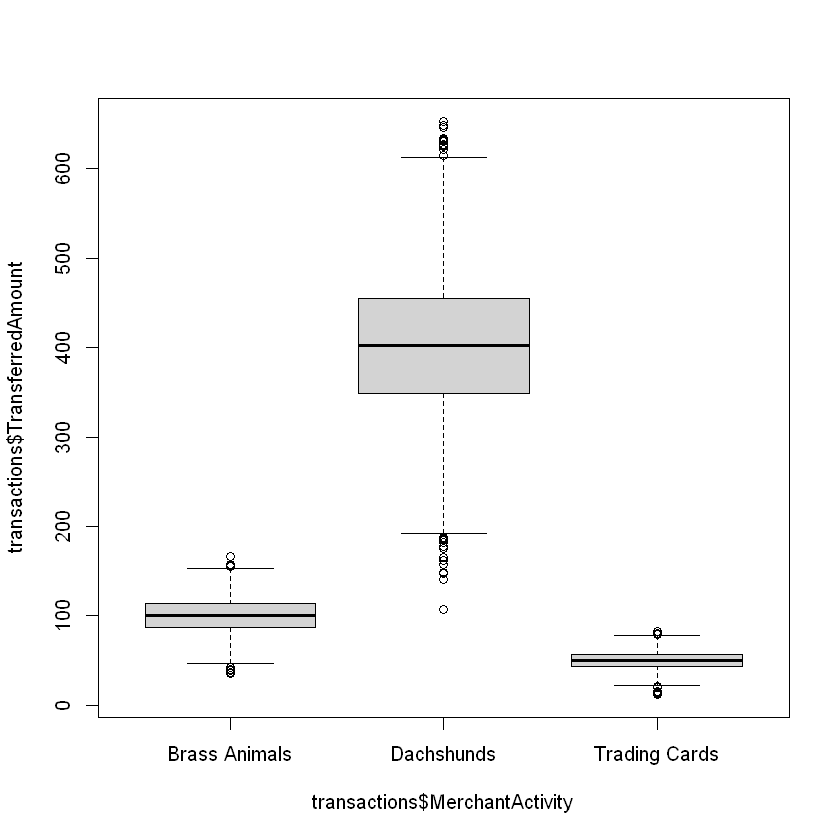

In [63]:
boxplot(transactions$TransferredAmount~transactions$MerchantActivity)

In [64]:
model <- lm(transactions$TransferredAmount~transactions$MerchantActivity)
summary(model)


Call:
lm(formula = transactions$TransferredAmount ~ transactions$MerchantActivity)

Residuals:
    Min      1Q  Median      3Q     Max 
-294.60  -16.12    0.27   16.40  251.40 

Coefficients:
                                           Estimate Std. Error t value Pr(>|t|)
(Intercept)                                 100.120      1.417   70.67   <2e-16
transactions$MerchantActivityDachshunds     301.479      1.678  179.62   <2e-16
transactions$MerchantActivityTrading Cards  -50.390      1.769  -28.49   <2e-16
                                              
(Intercept)                                ***
transactions$MerchantActivityDachshunds    ***
transactions$MerchantActivityTrading Cards ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 55.14 on 7977 degrees of freedom
Multiple R-squared:  0.9023,	Adjusted R-squared:  0.9023 
F-statistic: 3.683e+04 on 2 and 7977 DF,  p-value: < 2.2e-16


As we get a **p-value of 2.2e-16**, we can definively say that there is a correlation between the transferred amount and the merchant activity